#  This document is the exploratory data analysis for problems of anomaly with some of Sysmex's analyzers

## Part 1: Exploratory Data Analysis

This part is to explore data, transform and understand the data provided by Sysmex

In [1]:
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import numpy.random as rnd
import os
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split 
#import findspark
#findspark.init()
import pyspark
from pyspark.sql.functions import *

# to make this notebook's output stable across runs
from IPython.display import display, HTML

from tensorflow.python.framework import random_seed

rnd.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "events", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=50)


In [4]:
from pyspark import SparkContext

In [5]:
sc = SparkContext()

In [6]:
from pyspark.sql import SparkSession

In [7]:
spark = SparkSession.builder.appName("W205 Final").config("spark.some.config.option", "some-value").getOrCreate()

In [8]:
#Load csv data to spark frame objects (distributed) and create columns names for these dataframe objects. You can replace these 
#loading code with hive table loading to load to hive tables. 
data_path = 'C:/Temp/w205finalprojdata/'

test_flagging = spark.read.csv(data_path + 'Test Flagging Query Data Set.csv', header =False)
test_flagging = test_flagging.select(col("_c0").alias("Prod_ID"), col("_c1").alias("Count_Date"), col("_c2").alias("IPU_Ver"),col("_c3").alias("Count_Val"), col("_c4").alias("Counter") )

qc_raw = spark.read.csv(data_path + 'Specific QC Lot Number Results.csv', header =False)
qc_raw = qc_raw.select(col("_c0").alias("Prod_ID"), col("_c1").alias("QC_Lot"), col("_c2").alias("QC_Time"),col("_c3").alias("W-X"), col("_c4").alias("W-Y"),col("_c5").alias("W-Z") )

machine_raw = spark.read.csv(data_path + 'Reference Set A Result Set.csv')
machine_raw = machine_raw.select(col("_c0").alias("Prod_ID"), col("_c1").alias("Ser_No"), col("_c2").alias("Model_ID"),col("_c3").alias("IPU_Ver"), col("_c4").alias("Upgrade_Date") )

x_bar_raw = spark.read.csv(data_path + 'XBarM Result Set for Steve (CSV Form Revised).csv', header = False)
x_bar_raw = x_bar_raw.select(col("_c0").alias("Prod_ID"), col("_c1").alias("X_Bar_Run_Date_Time"), col("_c2").alias("X_Bar_M_X"),col("_c3").alias("X_Bar_M_Y"), col("_c4").alias("X_Bar_M_Z") )


In [9]:
#Store dataframe data to tables (Parquet format) so that we can later on we can refer to data in this warehouse
test_flagging.write.saveAsTable("Flagging_Raw")
qc_raw.write.saveAsTable("QC_Raw")
machine_raw.write.saveAsTable("Machine_Raw")
x_bar_raw.write.saveAsTable("XBar_Raw")


In [10]:
#Now we perform data joining to construct data objets that we need.
#First, we want a QC data object that have not only QC data but also machine data with it. We also
#Clean out null records from the data

#To prepare to retrieve the right IPU_Version for each QC or Flagging transaction, we will create new columns start_date and end date 
#in hat cover the valid time range for a particular IPU. One particular time range is determined to start from the 
#effective date of the software IPU Version to the next effective date if any. If there's no effective date of the  
#IPU Version then IPU_Ver is set to None. A dummy value of'12/31/2017' is for any transactions that happens after the last upgrade
#date to mean the IPU to use the latest IPU_Ver
#To do this 
qc_sql = spark.sql("select QC_Raw.*, X.IPU_Ver, X.Model_ID, X.Ser_No from QC_Raw left join (select A.Prod_ID, A.Ser_No, A.Model_ID, A.IPU_Ver, UNIX_TIMESTAMP(A.Upgrade_Date, 'MM/dd/yy hh:mm aa') Start_Date, case when B.Upgrade_Date !='None' THEN  unix_timestamp(B.Upgrade_Date, 'MM/dd/yy hh:mm aa') \
                        ELSE UNIX_TIMESTAMP('12/31/17 12:00 PM','MM/dd/yy hh:mm aa') END End_Date, B.IPU_Ver end_IPU from (Select *, rank()  over(partition by Prod_ID order by unix_timestamp(Upgrade_Date, 'MM/dd/yy hh:mm aa') \
                        ) rank from Machine_Raw) A left join (Select *, rank()  over(partition by Prod_ID order by unix_timestamp(Upgrade_Date, 'MM/dd/yy hh:mm aa') ) \
                        rank from Machine_Raw) B on A.Prod_ID = B.Prod_ID  and (A.rank = B.rank-1)) X on QC_Raw.Prod_ID = X.Prod_ID \
                        and UNIX_TIMESTAMP(QC_Raw.QC_Time, 'yyyy-MM-dd hh:mm:ss')>=X.Start_Date and UNIX_TIMESTAMP(QC_Raw.QC_Time, 'yyyy-MM-dd hh:mm:ss')<X.End_Date")


qc_data =qc_sql.toPandas()


In [11]:
#Doing the same thing as above for XBar data
x_bar_sql = spark.sql("select XBar_Raw.*, X.IPU_Ver,X.Model_ID, X.Ser_No from XBar_Raw left join (select A.Prod_ID, A.Ser_No, A.Model_ID, A.IPU_Ver, UNIX_TIMESTAMP(A.Upgrade_Date, 'MM/dd/yy hh:mm aa') Start_Date, case when B.Upgrade_Date !='None' THEN  unix_timestamp(B.Upgrade_Date, 'MM/dd/yy hh:mm aa') \
                        ELSE UNIX_TIMESTAMP('12/31/17 12:00 PM','MM/dd/yy hh:mm aa') END End_Date, B.IPU_Ver end_IPU from (Select *, rank()  over(partition by Prod_ID order by unix_timestamp(Upgrade_Date, 'MM/dd/yy hh:mm aa') \
                        ) rank from Machine_Raw) A left join (Select *, rank()  over(partition by Prod_ID order by unix_timestamp(Upgrade_Date, 'MM/dd/yy hh:mm aa') ) \
                        rank from Machine_Raw) B on A.Prod_ID = B.Prod_ID  and (A.rank = B.rank-1)) X on XBar_Raw.Prod_ID = X.Prod_ID \
                        and UNIX_TIMESTAMP(XBar_Raw.X_Bar_Run_Date_Time, 'yyyy-MM-dd hh:mm:ss')>=X.Start_Date and UNIX_TIMESTAMP(XBar_Raw.X_Bar_Run_Date_Time, 'yyyy-MM-dd hh:mm:ss')<X.End_Date")
x_bar_m = x_bar_sql.toPandas()

Py4JJavaError: An error occurred while calling o110.collectToPython.
: java.lang.OutOfMemoryError: Java heap space
	at org.apache.spark.sql.execution.SparkPlan$$anon$1.next(SparkPlan.scala:261)
	at org.apache.spark.sql.execution.SparkPlan$$anon$1.next(SparkPlan.scala:257)
	at scala.collection.Iterator$class.foreach(Iterator.scala:893)
	at org.apache.spark.sql.execution.SparkPlan$$anon$1.foreach(SparkPlan.scala:257)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeCollect$1.apply(SparkPlan.scala:279)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeCollect$1.apply(SparkPlan.scala:278)
	at scala.collection.IndexedSeqOptimized$class.foreach(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.ArrayOps$ofRef.foreach(ArrayOps.scala:186)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:278)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply$mcI$sp(Dataset.scala:2803)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:2800)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:2800)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:65)
	at org.apache.spark.sql.Dataset.withNewExecutionId(Dataset.scala:2823)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:2800)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:748)


In [12]:
#Doing the same thing as above for Flagging data

test_flagging_sql = spark.sql("select Flagging_Raw.*, X.IPU_Ver,X.Model_ID, X.Ser_No from Flagging_Raw left join (select A.Prod_ID, A.Ser_No, A.Model_ID, A.IPU_Ver, UNIX_TIMESTAMP(A.Upgrade_Date, 'MM/dd/yy hh:mm aa') Start_Date, case when B.Upgrade_Date !='None' THEN  unix_timestamp(B.Upgrade_Date, 'MM/dd/yy hh:mm aa') \
                        ELSE UNIX_TIMESTAMP('12/31/17 12:00 PM','MM/dd/yy hh:mm aa') END End_Date, B.IPU_Ver end_IPU from (Select *, rank()  over(partition by Prod_ID order by unix_timestamp(Upgrade_Date, 'MM/dd/yy hh:mm aa') \
                        ) rank from Machine_Raw) A left join (Select *, rank()  over(partition by Prod_ID order by unix_timestamp(Upgrade_Date, 'MM/dd/yy hh:mm aa') ) \
                        rank from Machine_Raw) B on A.Prod_ID = B.Prod_ID  and (A.rank = B.rank-1)) X on Flagging_Raw.Prod_ID = X.Prod_ID \
                        and UNIX_TIMESTAMP(Flagging_Raw.Count_Date, 'yyyy-MM-dd')>=X.Start_Date and UNIX_TIMESTAMP(Flagging_Raw.Count_Date, 'yyyy-MM-dd')<X.End_Date")
# test_flagging_sql = spark.sql("select Flagging_Raw.* from Flagging_Raw limit 20")


test_flagging = test_flagging_sql.toPandas()

Py4JJavaError: An error occurred while calling o139.collectToPython.
: java.lang.OutOfMemoryError: Java heap space


In [13]:
print('number of records in QC data with zero W-Z, W-Y, W-Z data {:10,d}'.format(np.sum((qc_data['W-X']=='0')&(qc_data['W-Y']=='0')&(qc_data['W-Z']=='0'))))
print('number of records in XBar data with zero W-Z, W-Y, W-Z data {:10,d}'.format(np.sum((x_bar_m['X_Bar_M_X']=='0')&(x_bar_m['X_Bar_M_Y']=='0')&(x_bar_m['X_Bar_M_Z']=='0'))))

number of records in QC data with zero W-Z, W-Y, W-Z data     18,071


NameError: name 'x_bar_m' is not defined

In [14]:
#This code is to clean up data (remove all zero records) and transfer to the type so that we can manipulate with Pandas

qc_data = qc_data[((qc_data['W-X']!='0')&(qc_data['W-Y']!='0')&(qc_data['W-Z']!='0'))]
qc_data['Prod_ID'] = qc_data['Prod_ID'].astype(str)
qc_data['W-X'] = qc_data['W-X'].astype(int)
qc_data['W-Y'] = qc_data['W-Y'].astype(int)
qc_data['W-Z'] = qc_data['W-Z'].astype(int)
qc_data['QC_Time'] = pd.to_datetime(qc_data['QC_Time'])
qc_data[['Ser_No', 'Model_ID']] = qc_data[['Ser_No', 'Model_ID']].bfill()
qc_data['IPU_Ver'] = qc_data['IPU_Ver'].fillna(value ='unknown_ver')

test_flagging['Prod_ID'] = test_flagging.Prod_ID.astype(str)
test_flagging['Count_Date'] = pd.to_datetime(test_flagging.Count_Date)
test_flagging['Count_Val'] = test_flagging['Count_Val'].astype(int)
test_flagging[['Ser_No', 'Model_ID']] = test_flagging[['Ser_No', 'Model_ID']].bfill()
test_flagging['IPU_Ver'] = test_flagging['IPU_Ver'].fillna(value ='unknown_ver')


x_bar_m['Prod_ID'] = x_bar_m.Prod_ID.astype(str)
x_bar_m['X_Bar_Run_Date_Time'] = pd.to_datetime(x_bar_m.X_Bar_Run_Date_Time)

x_bar_m['X_Bar_M_X'] = x_bar_m['X_Bar_M_X'].astype(int)
x_bar_m['X_Bar_M_Y'] = x_bar_m['X_Bar_M_Y'].astype(int)
x_bar_m['X_Bar_M_Z'] = x_bar_m['X_Bar_M_Z'].astype(int)
x_bar_m[['Ser_No', 'Model_ID']] = x_bar_m[['Ser_No', 'Model_ID']].bfill()
x_bar_m['IPU_Ver'] = x_bar_m['IPU_Ver'].fillna(value ='unknown_ver')




TypeError: unexpected type: <class 'type'>

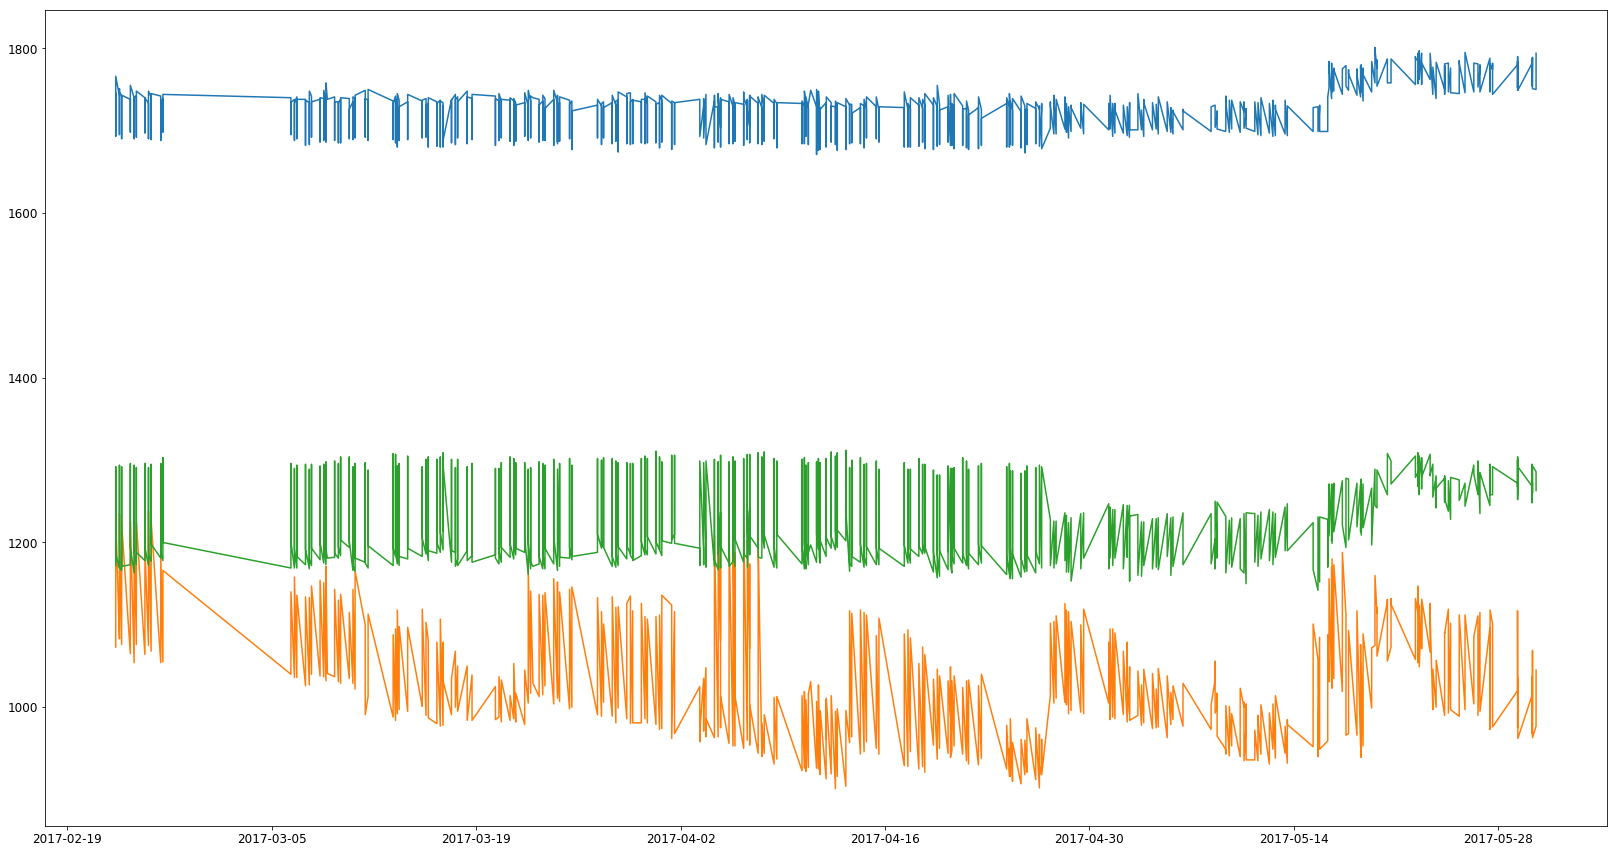

In [15]:
#Test with a plot to show time series data
t =qc_data[qc_data.Prod_ID =='148359'].sort_values('QC_Time')
fig, ax = plt.subplots(figsize =(28,15))


ax.plot(t.QC_Time, t['W-X'])
ax.plot(t.QC_Time, t['W-Y'])
ax.plot(t.QC_Time, t['W-Z'])


In [16]:
qc_data[qc_data.Prod_ID=='164186']

,Prod_ID,QC_Lot,QC_Time,W-X,W-Y,W-Z,IPU_Ver,Model_ID,Ser_No


In [241]:
#Summary data from test flagging
test_flagging.describe()

DataFrame[summary: string, Prod_ID: string, Count_Date: string, IPU_Ver: string, Count_Val: string, Counter: string]

In [239]:
#We may consider rewriting this with spark. 
def shift_date(x):
    x =x.sort_values('Count_Date')
    values= x['max'].copy().values
    values[1:] = values[0:len(values)-1]
    x['max'] = x['max'].values - values
   
    return x

X =test_flagging[(test_flagging.Counter!='CBCCounter')&(test_flagging.Counter!='DIFFCounter')].groupby(['Prod_ID', 'Counter','Count_Date'])['Count_Val'].aggregate(['max']).reset_index().groupby(['Prod_ID', 'Counter']).apply(shift_date)

# data_flagging_ver01 = X.unstack().fillna(0)

# data_flagging_ver01['Total_Flag'] = data_flagging_ver01.AtypicalLymphIPCounter + data_flagging_ver01.DimorphicPopulationIPCounter+ data_flagging_ver01.IGPresentIPCounter + data_flagging_ver01.LeftShiftIPCounter + data_flagging_ver01.PLTAbnDistribIPCounter+ data_flagging_ver01.RETAbnSctIPCounter + data_flagging_ver01.WBCAbnSctCounter
# data_flagging_ver01 =data_flagging_ver01.reset_index(level=[0, 1, 2])

# data_flagging_ver02 =data_flagging_ver01[data_flagging_ver01.WBModeCounter>0]

# data_flagging_ver02['AtypicalLymphIPCounter'] = data_flagging_ver02.AtypicalLymphIPCounter/data_flagging_ver02.WBModeCounter


# data_flagging_ver02['DimorphicPopulationIPCounter'] = data_flagging_ver02.DimorphicPopulationIPCounter/data_flagging_ver02.WBModeCounter
# data_flagging_ver02['IGPresentIPCounter'] = data_flagging_ver02.IGPresentIPCounter/data_flagging_ver02.WBModeCounter
# data_flagging_ver02['LeftShiftIPCounter'] = data_flagging_ver02.LeftShiftIPCounter/data_flagging_ver02.WBModeCounter


# data_flagging_ver02['PLTAbnDistribIPCounter'] = data_flagging_ver02.PLTAbnDistribIPCounter/data_flagging_ver02.WBModeCounter
# data_flagging_ver02['PLTAbnSctIPCounter'] = data_flagging_ver02.PLTAbnSctIPCounter/data_flagging_ver02.WBModeCounter


# data_flagging_ver02['RETAbnSctIPCounter'] = data_flagging_ver02.RETAbnSctIPCounter/data_flagging_ver02.WBModeCounter
# data_flagging_ver02['WBCAbnSctCounter'] = data_flagging_ver02.WBCAbnSctCounter/data_flagging_ver02.WBModeCounter
# data_flagging_ver02['Total_Flag'] = data_flagging_ver02.AtypicalLymphIPCounter + data_flagging_ver02.DimorphicPopulationIPCounter+ data_flagging_ver02.IGPresentIPCounter + data_flagging_ver02.LeftShiftIPCounter + data_flagging_ver02.PLTAbnDistribIPCounter+ data_flagging_ver02.RETAbnSctIPCounter + data_flagging_ver02.WBCAbnSctCounter






TypeError: 'GroupedData' object is not subscriptable

In [19]:
bar_data_label =data_flagging_ver02.groupby('IPU_Ver')['Total_Flag'].mean().sort_values()

NameError: name 'data_flagging_ver02' is not defined

In [23]:
bar_data =bar_data_label.values
bar_labels =bar_data_label.index

NameError: name 'bar_data_label' is not defined

In [ ]:
bar_data_label.index

In [24]:
n_groups =len(bar_data)
index = np.arange(n_groups)
bar_width = 0.6
opacity = 0.8



fig, ax = plt.subplots(figsize =(28,15))
ax.set_ylabel('Flagging rate (%)')
ax.set_title('Daily flagging rate among IPU Versions',fontsize=20)
ax.set_xticks(index + bar_width / 2)

rects1 = ax.bar(index, 100*bar_data, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Flag rates among IPU')
ax.set_xticklabels(bar_labels)
plt.show()

NameError: name 'bar_data' is not defined

In [ ]:
xbar_graph_data =x_bar_m.groupby(['IPU_Ver'])['X_Bar_M_X','X_Bar_M_Y', 'X_Bar_M_Z'].aggregate(np.std).mean(axis=1).sort_values()
xbar_bar_data =xbar_graph_data.values
xbar_bar_labels =xbar_graph_data.index

xbar_n_groups =len(xbar_bar_data)
xbar_index = np.arange(xbar_n_groups)
bar_width = 0.6
opacity = 0.8



fig_xbar, ax_xbar = plt.subplots(figsize =(28,15))
ax_xbar.set_ylabel('Standard Variance')
ax_xbar.set_title('Standard Variance  among IPU Versions',fontsize=20)
ax_xbar.set_xticks(xbar_index + bar_width / 2)

rects2 = ax_xbar.bar(xbar_index, xbar_bar_data, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Standard Variance  among IPUs')
ax_xbar.set_xticklabels(xbar_bar_labels)
plt.show()

In [ ]:
qc_graph_data=qc_data.groupby(['IPU_Ver'])['W-X','W-Y', 'W-Z'].aggregate(np.std).mean(axis =1).sort_values()

qc_bar_data =qc_graph_data.values
qc_bar_labels =qc_graph_data.index

qc_n_groups =len(qc_bar_data)
qc_index = np.arange(qc_n_groups)
bar_width = 0.6
opacity = 0.8



fig_qc, ax_qc = plt.subplots(figsize =(28,15))
ax_qc.set_ylabel('Standard Variance')
ax_qc.set_title('Standard QC result Variance  among IPU Versions',fontsize=20)
ax_qc.set_xticks(qc_index + bar_width / 2)

rects2 = ax_qc.bar(qc_index, qc_bar_data, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Standard Variance  among IPUs')
ax_qc.set_xticklabels(qc_bar_labels)
plt.show()

## Prediction Algorithm Development

In [17]:
transformed_qc_data = pd.get_dummies(qc_data[['QC_Lot', 'W-X', 'W-Y', 'W-Z', 'IPU_Ver', 'Model_ID']],columns =['IPU_Ver', 'Model_ID', 'QC_Lot']).values
train_data = transformed_qc_data[:2000000]




In [18]:
test_data = transformed_qc_data[2100000:]

test_data.shape

(317282, 41)

In [19]:

def format_test_data(test_data, n_steps):
    X = []
    Y = []
    max_test_range = test_data.shape[0]

    for start in range(max_test_range//n_steps):
        
        ys1 = test_data[start*n_steps: start*n_steps+n_steps]
        ys2 = test_data[start*n_steps+1: start*n_steps+n_steps+1,0:3]
        X.append(ys1)
        Y.append(ys2)
        
    X = np.array(X).reshape(-1, n_steps, 41)
    Y = np.array(Y).reshape(-1, n_steps, 3)
    return X, Y 
   

In [20]:
class DataSet(object):

  def __init__(self,
               data,
               indices,
               n_steps,
               fea_size,
               seed=None):
    seed1, seed2 = random_seed.get_seed(seed)
    # If op level seed is not set, use whatever graph level seed is returned
    np.random.seed(seed1 if seed is None else seed2)
    self._num_examples = int(len(indices)/n_steps)
    self._indices = indices
#     self._labels = labels
    self._n_steps = n_steps
    self._data = data

    self._epochs_completed = 0
    self._index_in_epoch = 0
    self._fea_size = fea_size
  @property
  def indices(self):
    return self._indices

  @property
  def fea_size(self):
    return self._fea_size

  @property
  def n_steps(self):
    return self._n_steps

  @property
  def num_examples(self):
    return self._num_examples
  @property
  def data(self):
    return self._data


  @property
  def epochs_completed(self):
    return self._epochs_completed


  def load(self, indices=[], batch_size=1):
    n_events= np.zeros(shape=(batch_size,self._n_steps,self._fea_size))
    m_events= np.zeros(shape=(batch_size,self._n_steps,3))

    
    for i,j in zip(indices,range(batch_size)):
#         print("start is", start)
#         print("end is", end)
#         print("i is", i)
#         print("")

        n_event = self._data[i*self._n_steps:(i+1)*self._n_steps]
        n_events[j] = np.array(n_event)
        m_event = self._data[i*self._n_steps+1:(i+1)*self._n_steps+1,0:3]
        m_events[j] = np.array(m_event)
#         print('n event shape is', n_event.shape)
#         print('m event shape is', m_event.shape)

#         print('n event is', n_event)
#         print('m event is', m_event)
#     print('n event shape', n_events.shape)
#     print('m event shape', m_events.shape)
#     print('n events is', n_events)
#     print('m events is', m_events)

    return n_events, m_events
   

  def next_batch(self, batch_size):
    """Return the next `batch_size` examples from this data set."""
    start = self._index_in_epoch
    if self._epochs_completed == 0 and start == 0:
      perm0 = np.arange(self._num_examples)
      self._indices = self.indices[perm0]
    # Go to the next epoch
    if start + batch_size > self._num_examples:
      # Finished epoch
      self._epochs_completed += 1
      # Get the rest examples in this epoch
      rest_num_examples = self._num_examples - start
      events_rest_part = self._indices[start:self._num_examples]
      # Start next epoch
      start = 0
      self._index_in_epoch = batch_size - rest_num_examples
      end = self._index_in_epoch
      events_new_part = self._indices[start:end]

      return self.load(np.concatenate((events_rest_part, events_new_part), axis =0), batch_size)
    else:
      self._index_in_epoch += batch_size
      end = self._index_in_epoch
        
#     n_events= np.zeros(shape=(batch_size,self._n_steps,41), dtype=np.uint8)
#     m_events= np.zeros(shape=(batch_size,self._n_steps,3), dtype=np.uint8)

    
#     for i,j in zip(range(start,end),range(batch_size)):
# #         print("start is", start)
# #         print("end is", end)
# #         print("i is", i)
# #         print("")

#         n_event = self._data[i*self._n_steps:(i+1)*self._n_steps]
#         n_events[j] = np.array(n_event)
#         m_event = self._data[i*self._n_steps+1:(i+1)*self._n_steps+1,0:3]
#         m_events[j] = np.array(m_event)
    return self.load((start,end), batch_size)


        

In [21]:
qc_events_data = DataSet(train_data,np.arange(0,2000000), 50,41)



In [22]:
tf.reset_default_graph()

n_steps = 50
n_inputs = 41
n_neurons = 100
n_outputs = 3
learning_rate = 0.001



X = tf.placeholder(tf.float32,[None, n_steps, n_inputs],name="X")
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs], name ='y')
# X_norm =tf.nn.l2_normalize(X, 2)
# y_norm = tf.nn.l2_normalize(y, 2)
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu),
    output_size=n_outputs)
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

loss = tf.reduce_sum(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)


n_epochs = 10
sm_batch_size = 50
sm_n_steps = 50
saver = tf.train.Saver()
sess = tf.Session()
for epoch in range(n_epochs):

    sess.run(tf.global_variables_initializer())
    for iteration in range(qc_events_data.num_examples // sm_batch_size):
        X_batch, y_batch = qc_events_data.next_batch(sm_batch_size)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 10 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch}, session =sess)
            print(iteration, "\tMSE:", mse)
tf.add_to_collection("outputs", outputs)

saver.save(sess, 'sysmex_anomaly_model1')


0 	MSE: 7.26838e+08
10 	MSE: 1.67581e+08
20 	MSE: 2.17817e+07
30 	MSE: 1.37339e+07
40 	MSE: 2.18595e+07
50 	MSE: 9.19815e+06
60 	MSE: 8.34052e+06
70 	MSE: 7.01836e+06
80 	MSE: 5.65417e+06
90 	MSE: 1.76352e+07
100 	MSE: 5.53999e+06
110 	MSE: 3.94686e+06
120 	MSE: 7.68854e+06
130 	MSE: 1.1733e+07
140 	MSE: 1.6937e+06
150 	MSE: 6.70225e+06
160 	MSE: 1.01048e+06
170 	MSE: 1.00957e+06
180 	MSE: 929759.0
190 	MSE: 2.01911e+06
200 	MSE: 4.37146e+06
210 	MSE: 1.74089e+06
220 	MSE: 1.30494e+07
230 	MSE: 2.31068e+06
240 	MSE: 253415.0
250 	MSE: 1.0812e+06
260 	MSE: 424959.0
270 	MSE: 299897.0
280 	MSE: 3.95786e+06
290 	MSE: 370963.0
300 	MSE: 2.96712e+06
310 	MSE: 321520.0
320 	MSE: 561766.0
330 	MSE: 355825.0
340 	MSE: 1.85656e+06
350 	MSE: 809477.0
360 	MSE: 1.48581e+06
370 	MSE: 435004.0
380 	MSE: 595973.0
390 	MSE: 666973.0
400 	MSE: 1.03414e+06
410 	MSE: 772841.0
420 	MSE: 1.00639e+06
430 	MSE: 299482.0
440 	MSE: 173035.0
450 	MSE: 789336.0
460 	MSE: 823717.0
470 	MSE: 859533.0
480 	MSE: 99

ValueError: could not broadcast input array from shape (0,41) into shape (50,41)

In [145]:
# def format_mock_data(test_data, n_steps):
#     X = []
#     Y = []
#     max_test_range = test_data.shape[0]

#     for start in range(max_test_range//n_steps):
        
#         ys1 = test_data[start*n_steps: start*n_steps+n_steps]
#         ys2 = test_data[start*n_steps+1: start*n_steps+n_steps+1,0:3]
#         X.append(ys1)
#         Y.append(ys2)
        
#     X = np.array(X).reshape(-1, n_steps, 12)
#     Y = np.array(Y).reshape(-1, n_steps, 3)
#     return X, Y 

In [352]:
# for i in range(0,50):
#     pred_data, act_data, flag = gen_data()
#     print(len(queue))
#     print(pred_data)
#     print(act_data)
#     print(flag)
gen_data(1, 200)

n event shape (1, 1, 41)
m event shape (1, 1, 3)
INFO:tensorflow:Restoring parameters from /tmp/my_model_final.ckpt


(array([ 1629.57250977,   673.84051514,  1646.82995605], dtype=float32),
 array([ 1723.,  1155.,  1298.]),
 True)

In [300]:
# raw_data = pd.get_dummies(qc_data[qc_data.Prod_ID =='148359'][['QC_Lot', 'W-X', 'W-Y', 'W-Z', 'IPU_Ver', 'Model_ID']],columns =['IPU_Ver', 'Model_ID', 'QC_Lot']).values
mock_data = DataSet(train_data,np.arange(0,2000000), 1,41)
queue =[]

In [322]:
def gen_data(num=1, threshold=500):
    global queue
    X_act, act_w = mock_data.next_batch(num)
    act_w = act_w.flatten()
    queue.append(X_act.flatten())
    pred_data=None
    flag = None
    if(len(queue)>50):
        queue = queue[:-1]
    if(len(queue)==50):
        pred_data,flag = predict(act_w, np.array(queue)[np.newaxis, :,:],threshold)
    return pred_data, act_w, flag

In [324]:
def predict(act_w, input_stream, threshold):

    with tf.Session() as sess:
        saver.restore(sess,"/tmp/my_model_final.ckpt")
        y_pred = sess.run(outputs, feed_dict={X: input_stream})
#     print("ypred shape", y_pred.shape)
    pred = y_pred.reshape(50,-1)[-1]
#     print("pred is", pred)
#     print("act_w is", act_w)
    var = np.sum(np.abs(act_w-pred))/3
    flag=var>threshold
    
    return pred, flag





In [87]:
X_test, Y_test = format_test_data(test_data, 50)
y_pred, abn_indices = predict(test_data, 600)

print("number of items:",abn_indices.shape )
Y_test.reshape(-1,3)[abn_indices,:]

INFO:tensorflow:Restoring parameters from /tmp/my_model_final.ckpt
number of items: (1063,)


array([[1607,  673, 1657],
       [1744,  935, 1251],
       [1733, 1010, 1287],
       ..., 
       [1754,  953, 1278],
       [1751, 1074, 1297],
       [1791, 1226, 1234]])

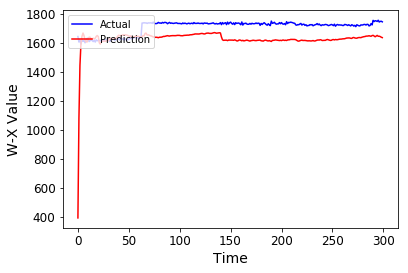

In [59]:

plt.plot(range(len(Y_test[0][:,0])),Y_test[0][:,0], color ='b', label ="Actual")

plt.plot(range(len(X_test[0][:,0])),y_pred[0][:,0], color='r',  label ="Prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")
plt.ylabel("W-X Value")

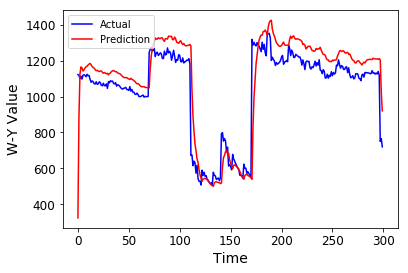

In [60]:


plt.plot(range(len(Y_test[1][:,1])),Y_test[1][:,1], color ='b', label ="Actual")

plt.plot(range(len(X_test[1][:,1])),y_pred[1][:,1], color='r',  label ="Prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")
plt.ylabel("W-Y Value")

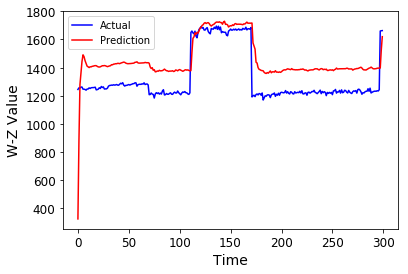

In [61]:

plt.plot(range(len(Y_test[1][:,2])),Y_test[1][:,2], color ='b', label ="Actual")

plt.plot(range(len(X_test[1][:,2])),y_pred[1][:,2], color='r',  label ="Prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")
plt.ylabel("W-Z Value")



In [33]:
sc

pyspark.context.SparkContext

In [ ]:
import numpy as np
import pandas as pd
import tensorflow tf

from bokeh.io import curdoc
from bokeh.models import ColumnDataSource
from bokeh.plotting import Figure, output_file, show

q_data = pd.read_csv('data/Sysmex/Data/Specific QC Lot Number Results.csv')
q_data.columns =['product_id', 'qc_lot', 'time', 'w-x', 'w-y', 'w-z']
q_data.dropna()

q_data.head()

my_data = dict(x=[], y1=[], y2=[], y3=[])
source = ColumnDataSource(my_data)

fig = Figure()
fig.line(source=source, x="x", y="y1", line_width=2, alpha=.85, color="red")
fig.line(source=source, x="x", y="y2", line_width=2, alpha=.85, color="blue")
fig.line(source=source, x="x", y="y3", line_width=2, alpha=.85, color="green")

ct = 0
w_x = 0
w_y = 0
w_z = 0
def update_data():
    global ct, w_x, w_y, w_z
    ct += 1
    temp_rec = q_data.iloc[[ct]]
    w_x = temp_rec["w-x"]
    w_y = temp_rec["w-y"]
    w_z = temp_rec["w-z"]
    new_data = dict(x=[ct], y1=[w_x], y2=[w_y], y3=[w_z])
    source.stream(new_data, 100)

curdoc().add_root(fig)
curdoc().add_periodic_callback(update_data, 100)